*Copyright (C) 2022-23 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

---

# Tutorial: Creating network motifs

**Motivation:** In this tutorial, we will provide a walkthrough on how to create custom network motifs with Lava-VA. The Lava-VA Network is a recursive hierarchical container for creating reusable components. Custom motifs can be created with basic python syntax and links to standard components of the Lava-VA Network.


In [1]:
from pylab import *

First, we will import the objects into the lv namespace and connect to Loihi 2.

In [2]:
import lava.frameworks.loihi2 as lv

In [3]:
from scipy.sparse import csr_matrix

In [4]:
from lava.utils import loihi

loihi.use_slurm_host(loihi_gen=loihi.ChipGeneration.N3B3)
use_loihi2 = loihi.is_installed()
#use_loihi2 = False

if use_loihi2:
    run_cfg = lv.Loihi2HwCfg()
    print("Running on Loihi 2")
else:
    run_cfg = lv.Loihi2SimCfg(select_tag='fixed_pt')
    print("Loihi2 compiler is not available in this system. "
          "This tutorial will execute on CPU backend.")

Running on Loihi 2


Our goal for this tutorial is to create a simple memory buffer network. This is also often called a shift register in standard digital electronics. 

In particular, our design will consist of a population of GradedVec neurons, which transmit graded spike values. We want to connect the population with a recurrent matrix, so that each value is transferred to the neighboring neuron on the next timestep. 

Further, we want to incorporate the operator overloading. To do so we can inherit from the AlgebraicVector class that includes the overloading function. 

In [5]:
from lava.networks.network import AlgebraicVector

class MemoryBuffer(AlgebraicVector):
    def __init__(self, shape):
        self.shape = shape
        
        # Create the weight matrix 
        rec_weights = np.roll(np.eye(self.shape[0]), 1, axis=0)
        
        # Instantiate the core Network objects
        self.main = lv.GradedVec(shape=shape, vth=1)
        self.buf_weights = lv.GradedSparse(weights=rec_weights)
        
        # Create the network motif by connecting the recurrent 
        # weights to the neural population
        self.main << self.buf_weights @ self.main

        # Connect the standard ports
        self.in_port = self.main.in_port
        self.out_port = self.main.out_port
        
        

Now that we've created our custom network motif, we can use it in a simulation.

In [6]:
num_steps = 20
mem_buffer_size = (50,)

In [7]:
inp_data = np.zeros((1, num_steps))

inp_data[:, 1] = 2
inp_data[:, 3] = 4
inp_data[:, 5] = 8
inp_data[:, 7] = 16
inp_data[:, 9] = 32
inp_data[:, 11] = 64

in_weights = np.zeros((mem_buffer_size[0], 1))
in_weights[0] = 1

In [8]:
invec = lv.InputVec(inp_data, loihi2=use_loihi2)

in_out_syn = lv.GradedDense(weights=in_weights)

memvec = MemoryBuffer(shape=mem_buffer_size)

out_monitor = lv.OutputVec(shape=mem_buffer_size, buffer=num_steps, loihi2=use_loihi2)


In [9]:
memvec << in_out_syn @ invec
out_monitor << memvec

In [10]:
try:
    memvec.run(condition=lv.RunSteps(num_steps=num_steps), 
            run_cfg=run_cfg)
    out_spike_data = out_monitor.get_data()
finally:
    memvec.stop()

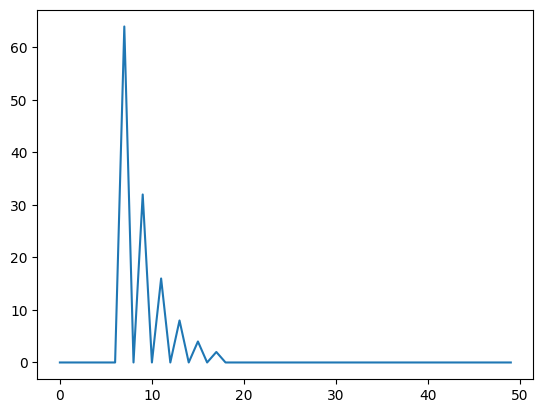

In [11]:
plot(out_spike_data[:, -1])


The above network shows the last timestep of the memory buffer in the simulation. Here, we turned a temporal pattern into a spatial pattern using a simple permutation motif. 